In [1]:
import os
from collections import OrderedDict

In [2]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [5]:
from common.multiprocessing_env import SubprocVecEnv

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0., std=0.1)
            nn.init.constant_(m.bias, 0.1)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [35]:
class Ppo:
    
    def __init__(self, inputVal):
        self.testRewards = []
        
#         self.num_envs = 16
        self.num_envs = inputVal
        self.env_name = "Pendulum-v0"
        self.env = gym.make(self.env_name)
        
        self.envs = [self.make_env() for i in range(self.num_envs)]
        self.envs = SubprocVecEnv(self.envs)
        
        self.num_inputs  = self.envs.observation_space.shape[0]
        self.num_outputs = self.envs.action_space.shape[0]

        #Hyper params:
        self.hidden_size      = 256
        self.lr               = 3e-3

        self.model = ActorCritic(self.num_inputs, self.num_outputs, self.hidden_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

            
    def make_env(self):
        def _thunk():
            env = gym.make(self.env_name)
            return env
        return _thunk        

    def compute_gae(self, next_value, rewards, masks, values, gamma=0.99, tau=0.95):
        values = values + [next_value]
        gae = 0
        returns = []
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
            gae = delta + gamma * tau * masks[step] * gae
            returns.insert(0, gae + values[step])
        return returns
    
    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.size(0)
        for ii in range(batch_size // mini_batch_size):
#             print ("ii: ", ii)
            rand_ids = np.random.randint(0, batch_size, mini_batch_size)
            yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
#             print ("log_probs:", log_probs)
            
    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
        all_losses = []
        for e in range(ppo_epochs):
#             print ("e: ", e)
            
            for state, action, old_log_probs, return_, advantage in self.ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
#                 print ("old_log_probs: ", old_log_probs)
                dist, value = self.model(state)
                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(action)

                ratio = (new_log_probs - old_log_probs).exp()
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

                actor_loss  = - torch.min(surr1, surr2).mean()
                critic_loss = (return_ - value).pow(2).mean()

                loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy
                
#                 if e == (ppo_epochs-1):
#                     epoch_loss.append(loss)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
#             if e == (ppo_epochs-1):
#                 all_losses.append(epoch_loss)
#             print ("all_losses: ", all_losses)
        return loss
#         return all_losses
                
    def plot(self, frame_idx, rewards):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
        plt.plot(rewards)
        plt.show()
        
    def test_env(self, vis=False):
        state = self.env.reset()
        if vis: self.env.render()
        done = False
        total_reward = 0
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            dist, _ = self.model(state)
            next_state, reward, done, _ = self.env.step(dist.sample().cpu().numpy()[0])
            state = next_state
            if vis: self.env.render()
            total_reward += reward
        return total_reward
    
    def printThing(self):
        print("the thing3")

In [36]:
p = Ppo(6)
# # h = Helper()

# p.main()

[2018-06-14 18:29:29,819] Making new env: Pendulum-v0
[2018-06-14 18:29:29,884] Making new env: Pendulum-v0
[2018-06-14 18:29:29,931] Making new env: Pendulum-v0
[2018-06-14 18:29:29,981] Making new env: Pendulum-v0
[2018-06-14 18:29:30,035] Making new env: Pendulum-v0
[2018-06-14 18:29:30,076] Making new env: Pendulum-v0
[2018-06-14 18:29:30,129] Making new env: Pendulum-v0


In [9]:
p.printThing()

the thing3


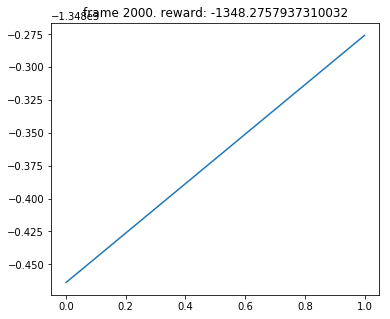

returns:  tensor([-4.7122], device='cuda:0')


In [38]:
#     def main(self):
num_inputs  = p.envs.observation_space.shape[0]
num_outputs = p.envs.action_space.shape[0]

#Hyper params:
#         hidden_size      = 256
#         lr               = 3e-3
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = -200

#         model = a.ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
#         optimizer = optim.Adam(self.model.parameters(), lr=lr)

#         max_frames = 15000
max_frames = 2000
frame_idx  = 0
test_rewards = []

state = p.envs.reset()
# print ("state: ", state)

early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = p.model(state)

        action = dist.sample()
        next_state, reward, done, _ = p.envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

        states.append(state)
        actions.append(action)

        state = next_state
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_reward = np.mean([p.test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            p.plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
#             print ("rewards: ", test_reward)


    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = p.model(next_state)
    returns = p.compute_gae(next_value, rewards, masks, values)
    
#     print ("returns: ", returns[])
#     print ("next_state: ", next_state)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    
#     print ("states later: ", states)

    lastLoss = p.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
#     print ("loss: ", [lastLoss])
            
# return lastLoss
re = returns[-1].cpu()
print ("returns: ", returns[-1])
# return np.asarray(re)

In [45]:
print (rewards[-1])

re = rewards[-1].cpu()
print (np.asarray(re))

tensor([[ -3.4254],
        [ -3.1753],
        [ -1.2876],
        [ -2.7729],
        [-15.7555],
        [-10.1583]], device='cuda:0')
[[ -3.4254036]
 [ -3.175332 ]
 [ -1.2876117]
 [ -2.7729468]
 [-15.755451 ]
 [-10.158283 ]]


In [17]:
print (returns)

tensor([[-254.5836],
        [-238.8372],
        [-194.0869],
        [-259.8807],
        [-179.6783],
        [-229.8962],
        [-243.7257],
        [-369.1578],
        [-255.1238],
        [-196.2774],
        [-190.2278],
        [-230.3572],
        [-217.0396],
        [-265.1531],
        [-238.0491],
        [-259.9486],
        [-251.0654],
        [-237.5690],
        [-187.6402],
        [-253.4544],
        [-174.5541],
        [-219.6727],
        [-242.7113],
        [-358.3169],
        [-252.0129],
        [-194.3573],
        [-179.0215],
        [-220.3250],
        [-216.1904],
        [-260.4563],
        [-221.2352],
        [-253.7601],
        [-246.7424],
        [-235.8473],
        [-182.0923],
        [-245.2713],
        [-169.7674],
        [-211.5127],
        [-241.2239],
        [-346.5844],
        [-247.9979],
        [-192.1835],
        [-168.7390],
        [-211.5092],
        [-214.9475],
        [-253.7784],
        [-203.3075],
        [-245

In [40]:
print (lastLoss.item())

5347.81005859375


In [11]:
# class functions:
#     def plot(self):
#         print ("not implemented")

class PpoImport:
    def __init__(self):
        self.input_dim = 2
        self.bounds= OrderedDict([('lambda', (0,1)), ('gamma',(0,1))])
        self.fmin = 1 #not sure what this is
        self.min = [(0.)*self.input_dim]  #not sure what this is either
        self.ismax = 1 #not sure what this is
        self.name='ppoGAE_import'
        
    def func(self, X):
        X = np.asarray(X)
        
        print (X)
        
        p = Ppo()
        ll = p.main(X)
        print ("ll: ", ll)
    #returns the rewardFunction*self.ismax

In [13]:
k = PpoImport()
X = 
k.func()

#  l = [np.random.uniform(x[0], x[1], size=n_init_points) for x in self.bounds]

#         # Concatenate new random points to possible existing
#         # points from self.explore method.
#         temp=np.asarray(l)
#         temp=temp.T
#         init_X=list(temp.reshape((n_init_points,-1)))
        
# self.X_original = np.asarray(init_X)

TypeError: func() missing 1 required positional argument: 'X'

In [32]:
bounds = [3, 2]
x = [0, 1]

print (np.random.uniform(2, 3, size=3))
print (x[0])


for x in bounds:
    print (np.random.uniform(0,1, size=3))

# thing = [np.random.uniform(x[0], x[1], size=3) for x in bounds]
# print (thing)

[2.71699976 2.35604717 2.42031545]
0
[0.32344136 0.25068585 0.18056927]
[0.70622877 0.23281556 0.31714475]
